In [1]:
import importlib
import sys, os
sys.path.insert(0, os.path.abspath("../src"))
import lpkit.read_sl1000 as sl1000
import lpkit.langmuir as lp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook" 

In [2]:
importlib.reload(sl1000)
importlib.reload(lp)
#npz_file = '../data/CB0020.npz'
#npz_file = '../data/20250206-He-plasma-01.npz'
#npz_file = '../data/20250206-He-plasma-preanode.npz'
npz_file = '../data/20250210-He-plasma-preanode-60V.npz'
df, metadata = sl1000.read_npz_file(npz_file)
param = dict(window=[0.59,3],peak_distance=0.095,peak_height=0.01,time_offset=-0.05)
#param = dict(window=[0.57,10],peak_distance=0.9,peak_height=0.1,time_offset=0.35)
data = lp.process_lp_data(df,metadata,**param)

In [14]:
importlib.reload(lp)
fig = lp.plot_raw_data_plotly(data,downdampling=10)

In [4]:
importlib.reload(lp)
cur = data['current_filtered']
v = data['voltage_filtered']
mask = data['mask']
im, vm = lp.apply_mask(mask,cur,v)

segments = lp.make_segments(data)
av, ai = lp.average_segments(segments)

In [13]:
factor=10
fig = go.Figure()
fig.add_trace(go.Scattergl(
    x=vm[::factor]*1000,
    y=-im[::factor]*100,
    mode='markers',
    marker=dict(size=2, color='#cffdff'), 
    opacity=0.1,
    name = 'data'
    ))
fig.add_trace(go.Scattergl(x=  av*1000,y = ai*100,name='averaged'))

fig.add_vline(x=0, line=dict(color="#d5ffc2", width=4),layer="below")
fig.add_hline(y=0, line=dict(color="#d5ffc2", width=4),layer="below")
fig.update_layout(
    title="Averaged I-V curve",
    xaxis_title="Voltage (V)",
    yaxis_title="Current (mA)",
    legend_title="Legend",
)

lp.plotly_style_dark(fig)
fig.show()

In [6]:
from matplotlib import rc
#rc("font", family="serif", serif=["Palatino"])
#rc("font", family="serif", serif=["Arial"])
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["DejaVu Serif"]
rc('text', usetex=False)

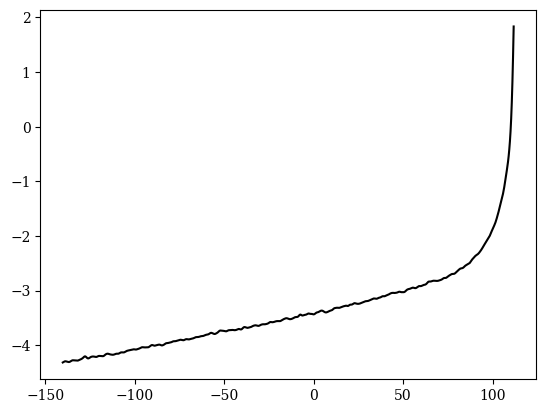

In [7]:
lend = -180
lstart  = 100
plt.plot(av[lstart:lend]*1000,ai[lstart:lend]*100,'k',label='IV data')

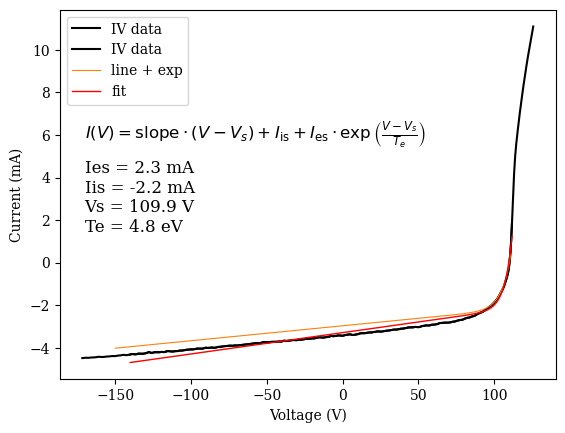

In [8]:
importlib.reload(lp)
x = np.linspace(-150,111,1000)

#init_params = dict(iis=-0.0088, ies=0.015, vs=120.4, te=5, slope=0.000_01)
init_params = dict(iis=-0.0022, ies=0.0022, vs=110, te=6, slope=0.000_007)

param_list = [init_params[k] for k in ["iis", "ies", "vs", "te", "slope"]]
y = lp.prob_func(x, *param_list)

plt.plot(av[lstart:lend]*1000,ai[lstart:lend]*100,'k',label='IV data')
plt.plot(av[10:-140]*1000,ai[10:-140]*100,'k',label='IV data')
plt.plot(x,y*1000,'C1',label='line + exp',lw=0.8)

txt = r"$I(V) = \mathrm{slope} \cdot (V - V_s) + I_{\mathrm{is}}"
txt+= r"+ I_{\mathrm{es}} \cdot \exp\left(\frac{V - V_s}{T_e}\right)$"
plt.text(0.05, 0.65, txt, fontsize=12, transform=plt.gca().transAxes)
#txt = f'Ies = {Ies*1e3:.1f} mA\nIis = {Iis*1e3:.1f} mA\nVs = {Vs:.1f} V\nTe = {Te:.1f} eV'
#plt.text(0.05, 0.5, txt, fontsize=12, transform=plt.gca().transAxes)

res = lp.fit_lp(av[lstart:lend]*1000, ai[lstart:lend]/10,**init_params)
txt = f'Ies = {res.values['ies']*1e3:.1f} mA'
txt+= f'\nIis = {res.values['iis']*1e3:.1f} mA'
txt+=f'\nVs = {res.values['vs']:.1f} V\nTe = {res.values['te']:.1f} eV'
plt.text(0.05, 0.4, txt, fontsize=12, transform=plt.gca().transAxes)
plt.plot(av[lstart:lend]*1000,res.best_fit*1000,c='red',label='fit',lw=1)

plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')
plt.legend()
#plt.savefig('../out/iv_curve.png',dpi=300,bbox_inches='tight')

In [9]:
res